In [229]:
import os
import sys
import spotipy
import spotipy.util as util

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas

SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
SCOPE='user-library-read'
USERNAME = '29n1g5zgbzcs413wmovhqdguz'

plt.rcParams['figure.figsize'] = (20, 14)

In [230]:
token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

if not token:
    print("Can't get token for username", username)
    sys.exit(1)

sp = spotipy.Spotify(auth=token)

In [236]:
def get_all_genre_features(dataset_path):
    data_dict = {}

    for dirpath, __, files in os.walk(dataset_path):
        for f in files:
            feature_str = '_features'
            if f.endswith(feature_str):
                genre_name = f[:-len(feature_str)]
                fname = os.path.join(dirpath, f)
                with open(fname, 'rb') as data_file:
                    try:
                        data_dict[genre_name] = pickle.load(data_file)
                    except ModuleNotFoundError:
                        continue

    return data_dict

If we define the importance of a feature as the measure of the variability of the data for that feature, we can use PCA to assign each feature an importance value.

In [4]:
def sort_features_importance(data):
    data_columns = data.columns
    data_norm = scale(data)
    data_norm = pd.DataFrame(data_norm, columns=data_columns)
    
    feature_n = data.shape[1]

    pca = PCA()
    pca.fit(data_norm)
    
    features_importances = {x: 0 for x in range(feature_n)}
    
    for comp_i in range(feature_n):
        comp = pca.components_[comp_i]
        importances = comp * pca.explained_variance_ratio_[comp_i]

        for feature_i, importance in enumerate(importances):
            if importance > features_importances[feature_i]:
                features_importances[feature_i] = importance
    feature_indices = sorted(features_importances, key=lambda x: features_importances[x], reverse=True)

    return list(data_columns[feature_indices])

In [5]:
print(sort_features_importance(techno_features))
print(sort_features_importance(soul_features))
print(sort_features_importance(grunge_features))
print(sort_features_importance(rap_features))

['tempo', 'key', 'acousticness', 'instrumentalness', 'danceability', 'liveness', 'duration_ms', 'speechiness', 'valence', 'time_signature', 'mode', 'loudness', 'energy']
['acousticness', 'duration_ms', 'speechiness', 'liveness', 'instrumentalness', 'tempo', 'mode', 'loudness', 'key', 'energy', 'time_signature', 'valence', 'danceability']
['acousticness', 'key', 'duration_ms', 'instrumentalness', 'danceability', 'speechiness', 'liveness', 'time_signature', 'loudness', 'valence', 'tempo', 'mode', 'energy']
['duration_ms', 'key', 'speechiness', 'instrumentalness', 'liveness', 'mode', 'valence', 'time_signature', 'acousticness', 'danceability', 'tempo', 'loudness', 'energy']


In [245]:
def plot_pca(*data):
    dataset_lens = []
    data_names = []
    datasets = []
            
    for data_tuple in data:
        data_name, dataset = data_tuple
        dataset_lens.append(dataset.shape[0])
        data_names.append(data_name)
        datasets.append(dataset)

    colors = plt.cm.spectral(np.linspace(0, 1, len(data) + 2))
    data_columns = data[0][1].columns
    combined_data = np.vstack(datasets)

    data_norm = scale(combined_data)
    data_norm = pd.DataFrame(data_norm, columns=data_columns)
    
    pca = PCA(n_components=2)
    pca_combined_points = pca.fit_transform(data_norm)
    pca_points = []
    offset = 0
    
    for dataset_len in dataset_lens:
        pca_points.append(pca_combined_points[offset:dataset_len + offset, :])
        offset += dataset_len
    
    for pca_pointset, color in zip(pca_points, colors[1:]):
        plt.scatter(pca_pointset[:, 0], pca_pointset[:, 1], color=color)
        
    plt.legend(data_names)
    
    plt.show()

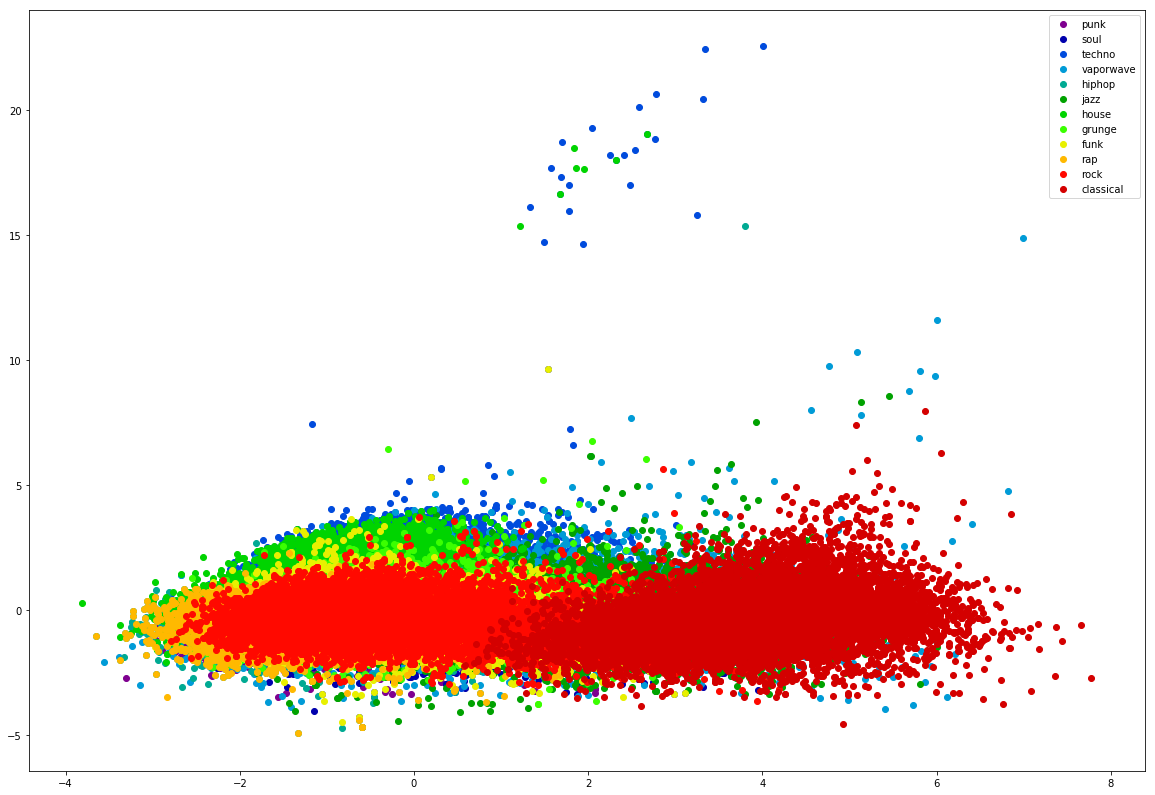

In [247]:
plot_pca(*list(get_all_genre_features('datasets').items()))

In [250]:
def mds(dists, max_dim=2):
    """Perform multidimensional scaling for a distance matrix
    http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/mvahtmlnode99.html"""
    N = dists.shape[0]
    centering_matrix = np.identity(N) - (np.ones((N, N)) / N) 
    A = np.array([[-0.5 * d ** 2 for d in row] for row in dists])
    B = np.dot(centering_matrix, np.dot(A, centering_matrix))
    w, v = np.linalg.eigh(B)

    # Sort eigen values.
    indices = np.argsort(w)[::-1]
    w = w[indices]
    v = v[:, indices]

    # Only positive values
    positives = np.where(w > 0)[0]
    final_dims = positives[:max_dim]
    lambda_mat = np.diag(w[final_dims])
    gamma = v[:, final_dims]
    
    return np.dot(gamma, lambda_mat ** 0.5)

In [286]:
def get_all_genre_features(dataset_path, max_samples=200):
    data_dict = {}

    for dirpath, __, files in os.walk(dataset_path):
        for f in files:
            feature_str = '_features'
            if f.endswith(feature_str):
                genre_name = f[:-len(feature_str)]
                fname = os.path.join(dirpath, f)
                with open(fname, 'rb') as data_file:
                    try:
                        df = pickle.load(data_file)
                        data_dict[genre_name] = df[:max_samples]
                    except ModuleNotFoundError:
                        continue

    return data_dict

In [287]:
all_data = get_all_genre_features('datasets')

In [288]:
all_data_list = list(all_data.items())

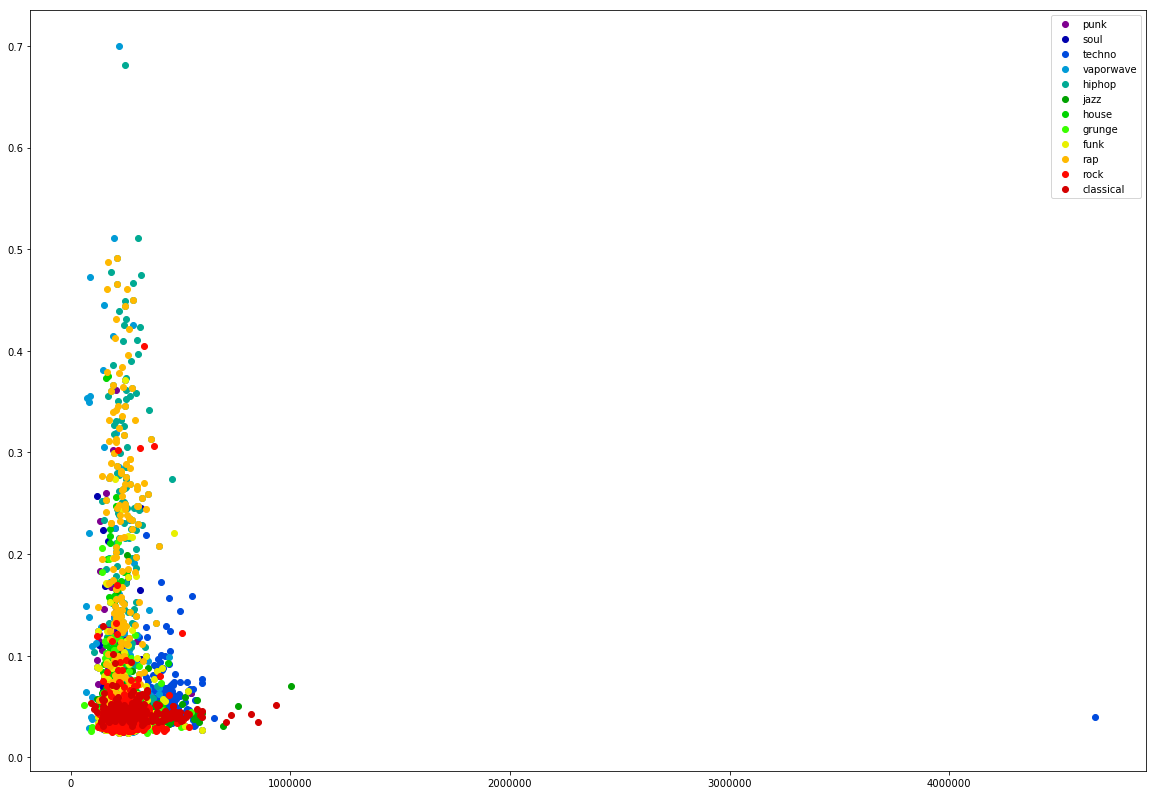

In [289]:
columns = all_data_list[0][1].columns
colors = plt.cm.spectral(np.linspace(0, 1, len(all_data_list) + 2))
data_names = []

for (data_name, data_list), color in zip(all_data_list, colors[1:]):
    data_names.append(data_name)
    data_df = pd.DataFrame(data_list, columns=columns)
    plt.scatter(data_df.duration_ms, data_df.speechiness, color=color)

    
plt.legend(data_names)
plt.show()